<h2 align=center> Facial Expression Recognition with Keras</h2>

### Import Libraries

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline
# !pip install livelossplot==0.5.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


### Plot Sample Image

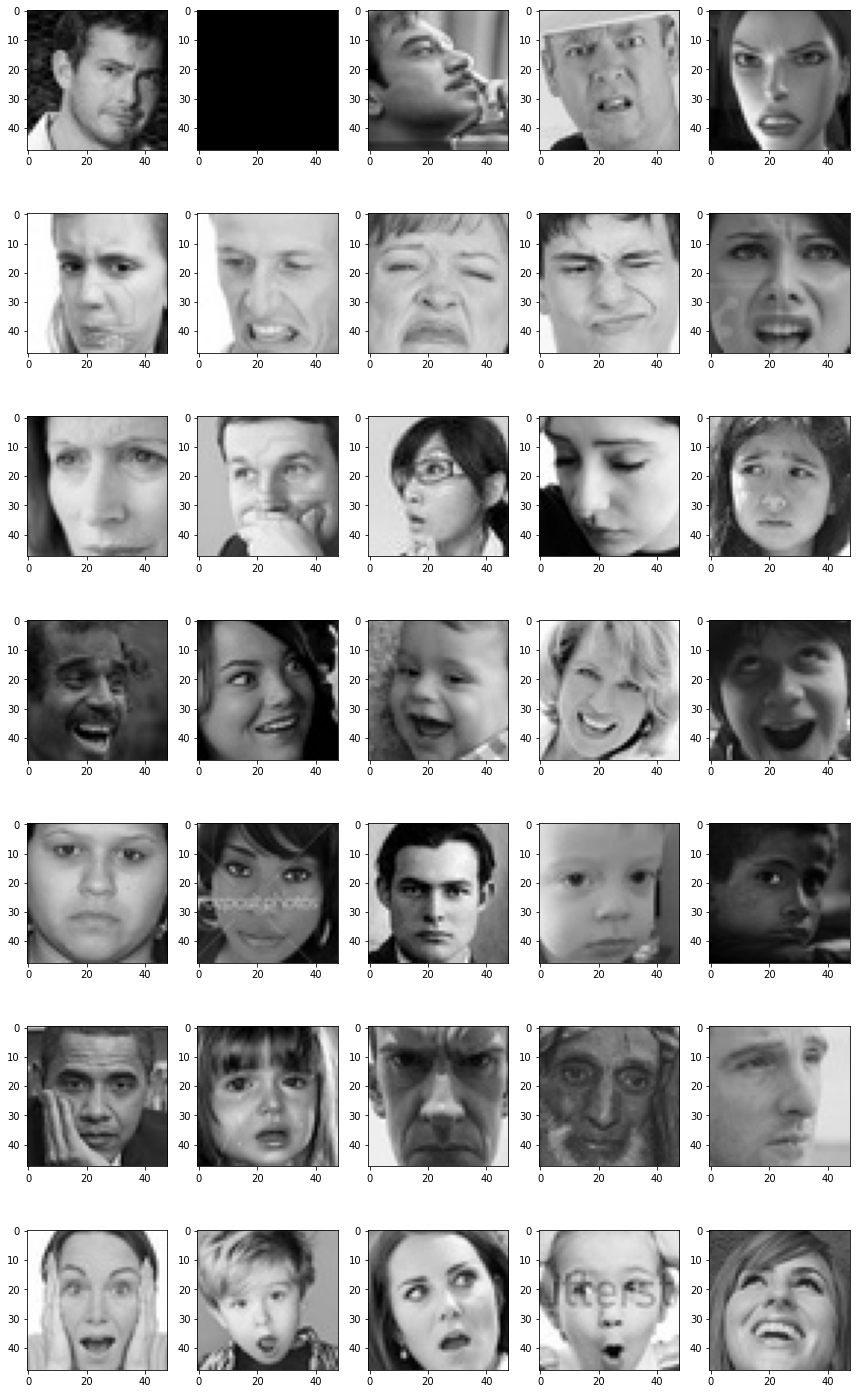

In [19]:
utils.datasets.fer.plot_example_images(plt).show()

In [20]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+ " "+ expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


### Generate Training and Validation Batches

In [21]:
img_size  = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [22]:
model = Sequential()

#1 - conv
model.add(Conv2D(64, (3,3), padding = 'same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2 - conv layer
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# 3- conv layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# 4 - conv layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(7,activation='softmax'))
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 128)      

In [23]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [24]:
import keras
keras.__version__

'2.6.0'

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 317005571220805274
xla_global_id: -1
]


### Train and Evaluate Model

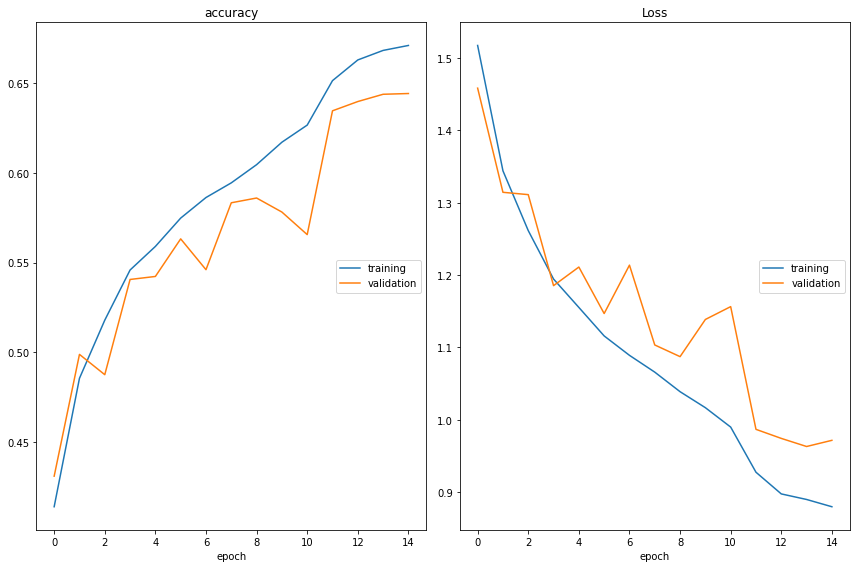

accuracy
	training         	 (min:    0.414, max:    0.671, cur:    0.671)
	validation       	 (min:    0.431, max:    0.644, cur:    0.644)
Loss
	training         	 (min:    0.880, max:    1.517, cur:    0.880)
	validation       	 (min:    0.963, max:    1.458, cur:    0.972)

Epoch 00015: saving model to model_weights.h5


In [28]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_acccuracy',
                            save_weigths_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience =2, min_lr=0.00001, model = 'auto')
callbacks = [ PlotLossesKeras(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

### Represent Model as JSON String

In [29]:
model_json = model.to_json()
with open ("model.json", "w") as json_file:
    json_file.write(model_json)